In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [3]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [4]:
ids = next(os.walk(r"C:\Users\amans\OneDrive\Desktop\competition_data\competition_data\train\images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [5]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [6]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(r'C:\Users\amans\OneDrive\Desktop\competition_data\competition_data\train\images/' +id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(r'C:\Users\amans\OneDrive\Desktop\competition_data\competition_data\train\masks/' +id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

C:\Users\amans\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\amans\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [7]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Salt')

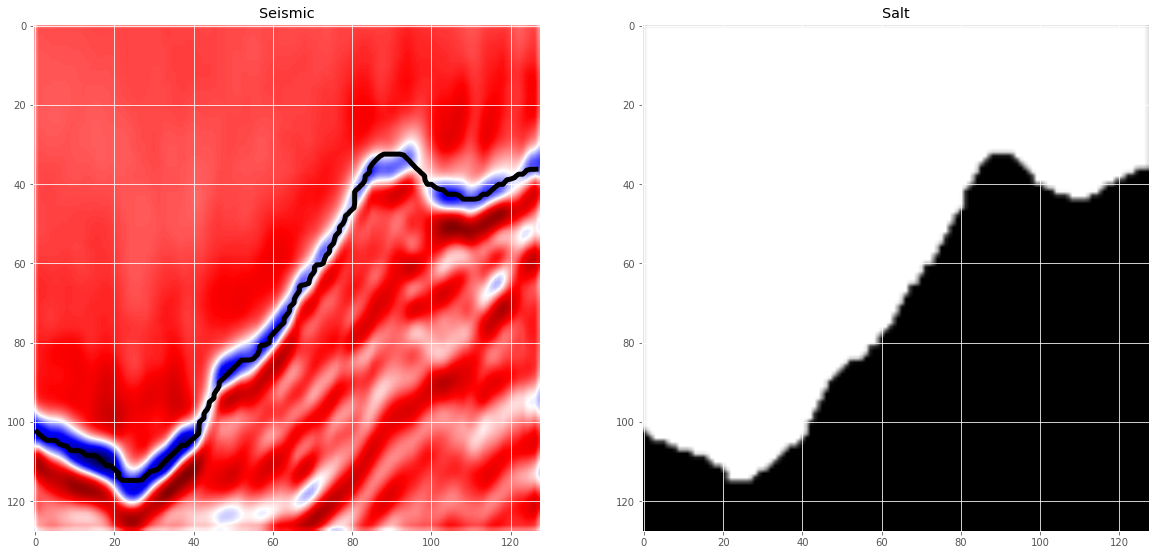

In [20]:
# Visualize any random image along with the mask
#ix = random.randint(0, len(X_train))
ix = 2
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix].squeeze(), cmap = 'seismic', interpolation = 'bilinear')

if has_mask: 
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')


In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [15]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [16]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [18]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [19]:
results = model.fit(X_train, y_train, batch_size=32, epochs=1, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

113/113 [==============================] - ETA: 4s - loss: 0.6879 - accuracy: 0.58 - ETA: 5:40 - loss: 0.6710 - accuracy: 0.60 - ETA: 6:07 - loss: 0.6624 - accuracy: 0.61 - ETA: 6:09 - loss: 0.6538 - accuracy: 0.62 - ETA: 6:02 - loss: 0.6449 - accuracy: 0.64 - ETA: 5:58 - loss: 0.6368 - accuracy: 0.65 - ETA: 5:54 - loss: 0.6296 - accuracy: 0.66 - ETA: 5:48 - loss: 0.6221 - accuracy: 0.67 - ETA: 5:46 - loss: 0.6153 - accuracy: 0.68 - ETA: 5:41 - loss: 0.6030 - accuracy: 0.69 - ETA: 5:37 - loss: 0.5978 - accuracy: 0.70 - ETA: 5:33 - loss: 0.5910 - accuracy: 0.70 - ETA: 5:30 - loss: 0.5839 - accuracy: 0.71 - ETA: 5:25 - loss: 0.5777 - accuracy: 0.71 - ETA: 5:21 - loss: 0.5751 - accuracy: 0.72 - ETA: 5:16 - loss: 0.5718 - accuracy: 0.72 - ETA: 5:13 - loss: 0.5679 - accuracy: 0.72 - ETA: 5:09 - loss: 0.5587 - accuracy: 0.73 - ETA: 5:04 - loss: 0.5581 - accuracy: 0.73 - ETA: 5:00 - loss: 0.5510 - accuracy: 0.73 - ETA: 4:56 - loss: 0.5451 - accuracy: 0.74 - ETA: 4:51 - loss: 0.5398 - accuracy

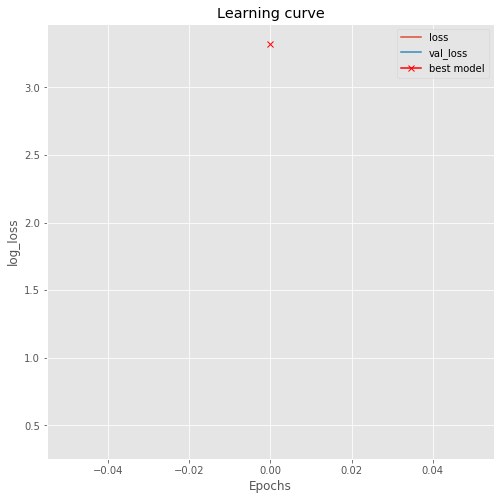

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [24]:
# load the best model
model.load_weights('model-tgs-salt.h5')

NameError: name 'model' is not defined

In [25]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

NameError: name 'model' is not defined

In [26]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

NameError: name 'model' is not defined

In [24]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [22]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

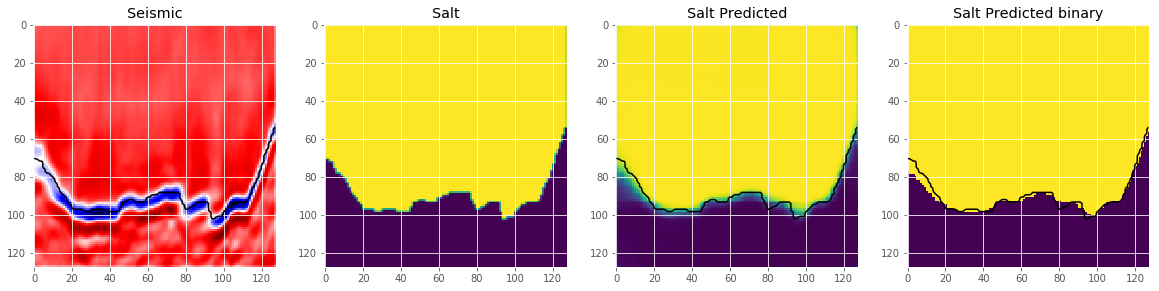

In [19]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

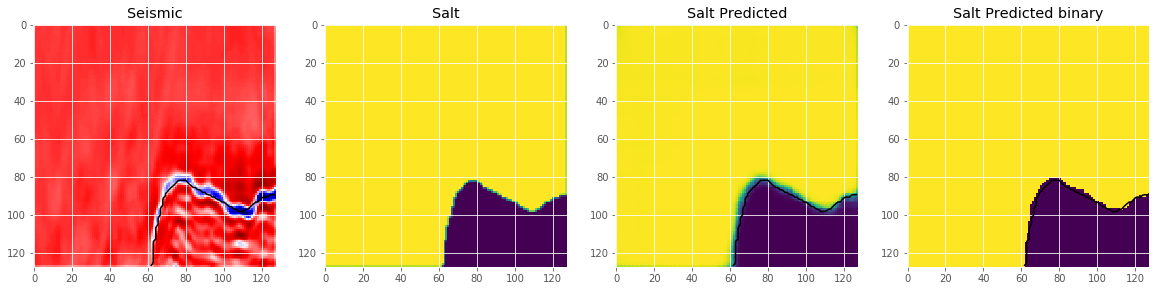

In [21]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

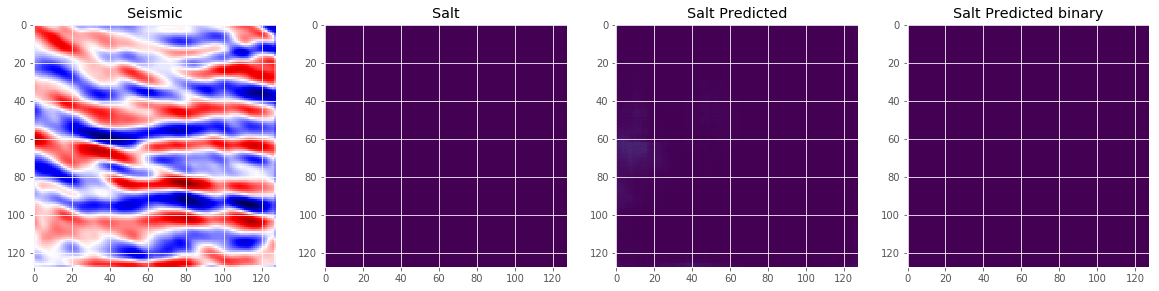

In [25]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

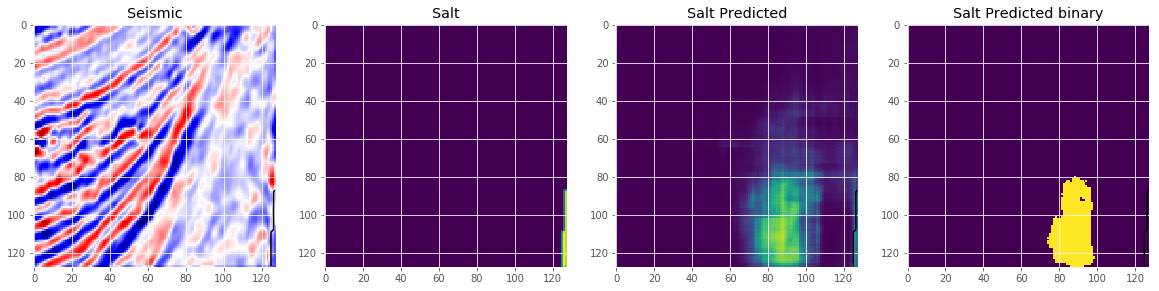

In [25]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

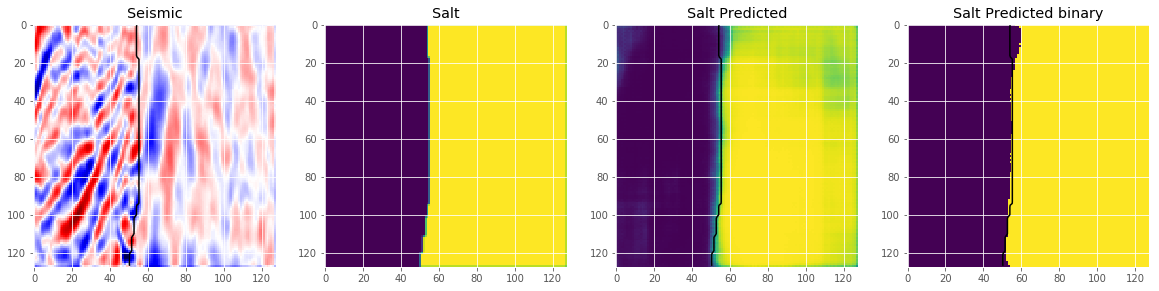

In [26]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

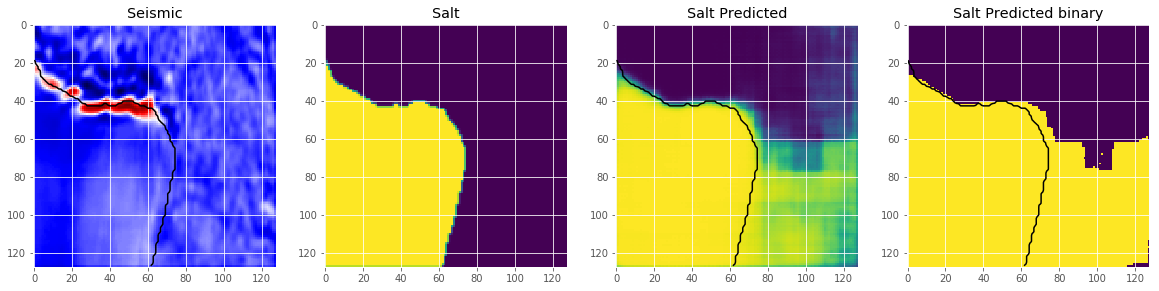

In [27]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

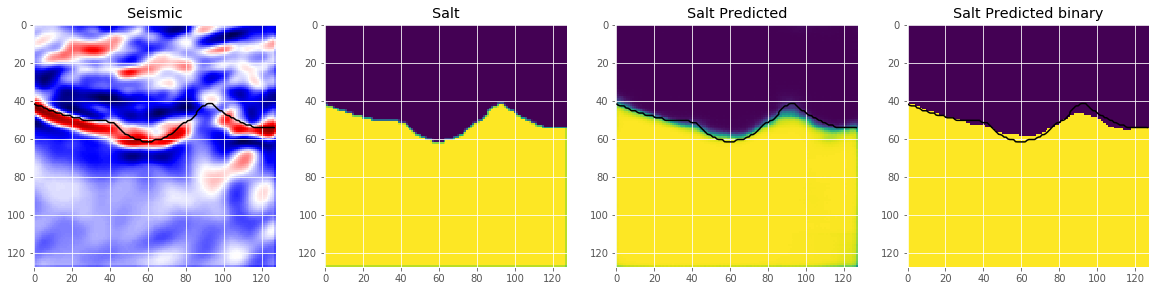

In [28]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

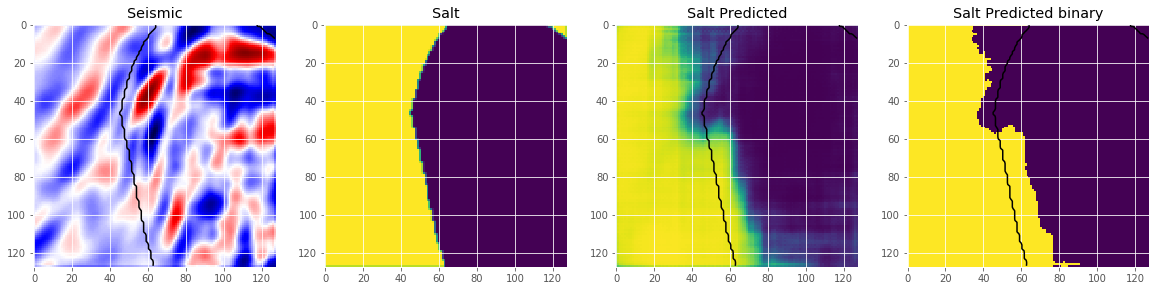

In [29]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

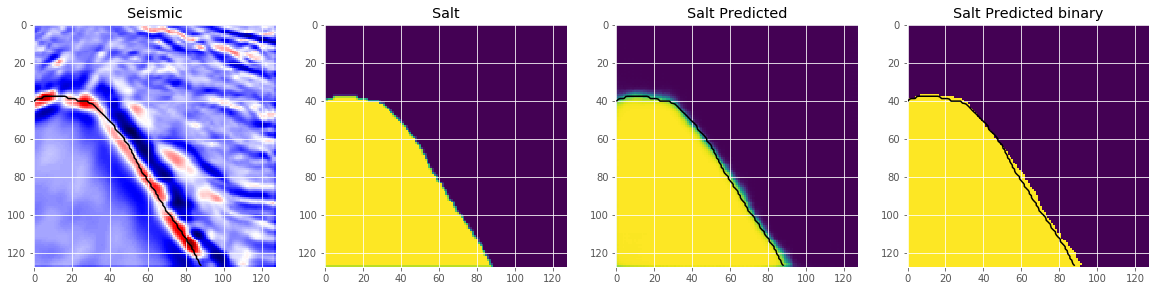

In [30]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

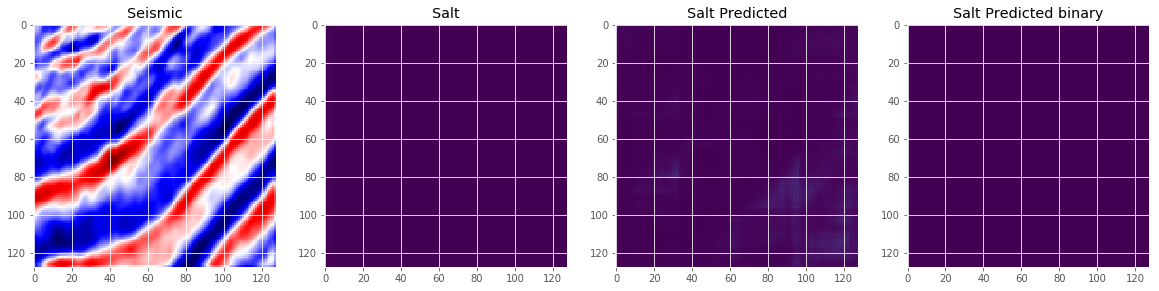

In [31]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

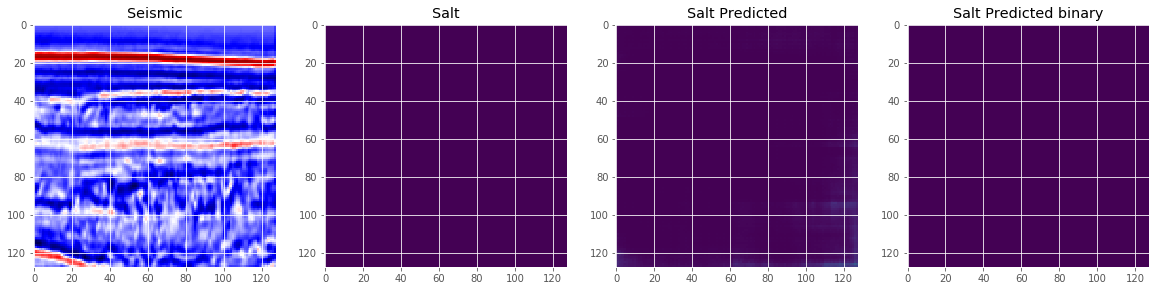

In [32]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

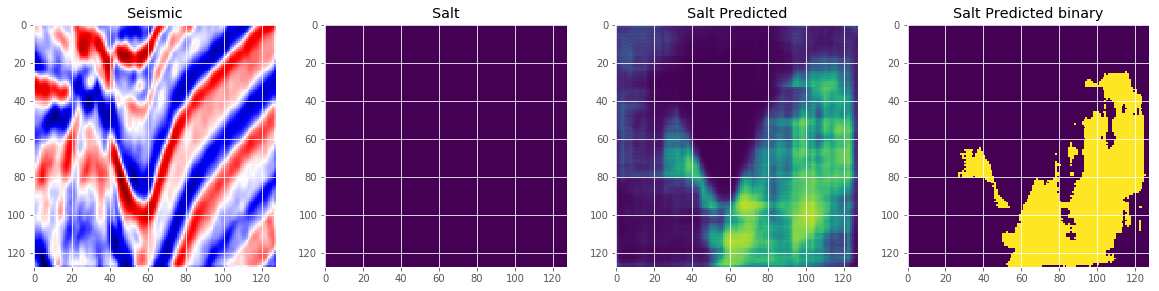

In [33]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

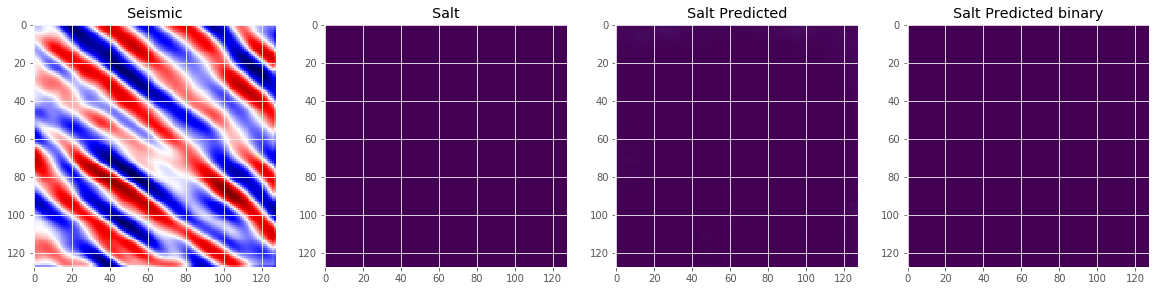

In [34]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

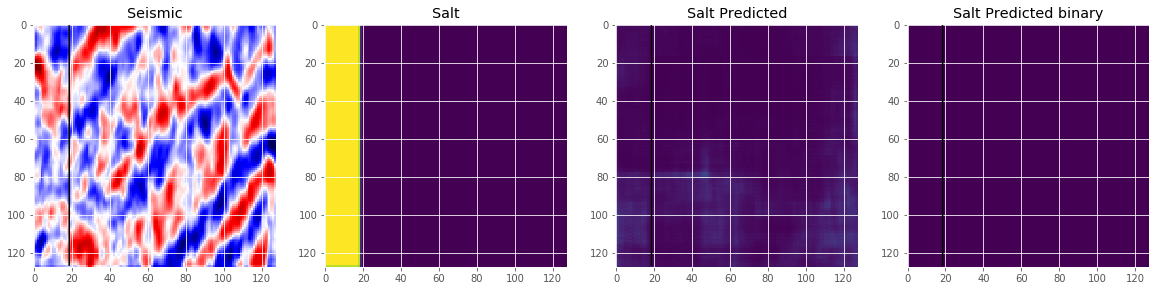

In [35]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

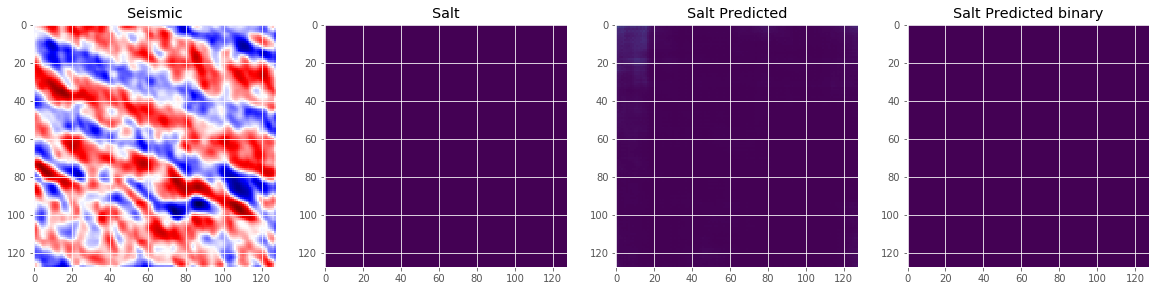

In [36]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

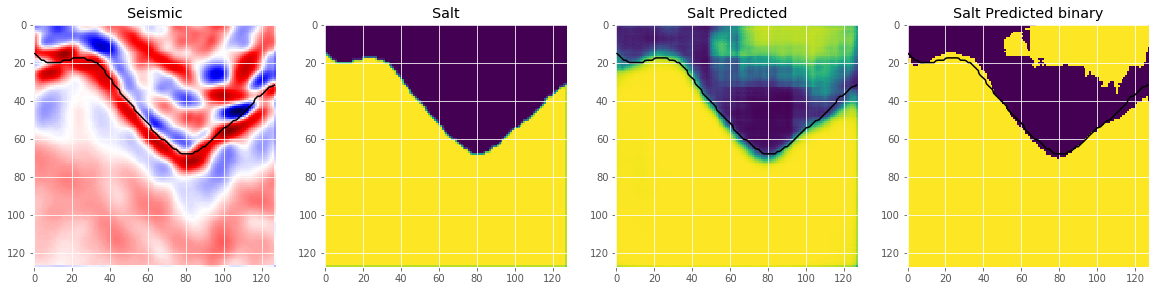

In [37]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

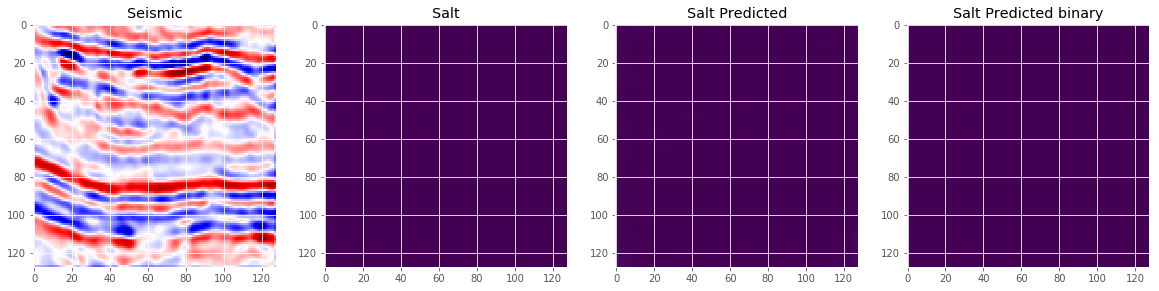

In [38]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

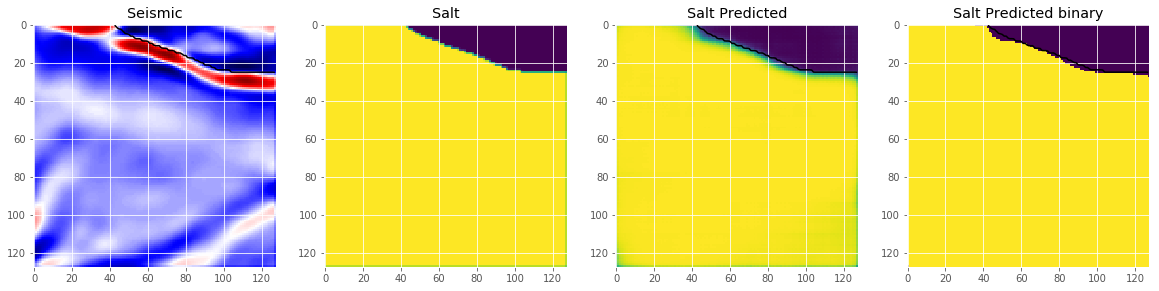

In [39]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)